IMPORTANDO BIBLIOTECAS

In [2]:
import os, shutil, sys, warnings
import errno
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

PARAMETRIZAÇÃO DA APLICAÇÃO

In [6]:
# basedirwin = 'D:\\Git\\IBMEC\\Projeto-DAeA\\Dataset\\CSVS\\' # PC
# fonte = 'D:\\Git\\IBMEC\\Projeto-DAeA\\CSVS\\' # PC
#################################################################
basedirwin = 'C:\\Git\\Projeto-DAeA\\Dataset\\CSVS\\' #Notebook
fonte = 'C:\\Git\\Projeto-DAeA\\CSVS\\' # Notebook
#################################################################
warnings.simplefilter(action='ignore', category=FutureWarning)

REMOVE CSVs VELHOS E COPIA OS NOVOS

In [7]:
if os.path.exists(basedirwin):
    shutil.rmtree(basedirwin)
else:
    sys.exit("Erro ao apagar o diretório de CSVs antigos. Não encontrado.")

try:
    shutil.copytree(fonte, basedirwin, dirs_exist_ok=True)
except OSError as err:
    sys.exit("Erro copiando a pasta de CSVs novos: % s" % err)

GERANDO LISTA DE PASTAS

In [8]:
try:
    listadir = os.listdir(basedirwin)
except OSError as err:
    if err.errno == errno.ENOENT:
        sys.exit("Erro listando o diretório de CSVs fonte: % s" % err)

FORMATANDO O ARQUIVO DE VOLUMES

In [9]:
for dir in listadir:
    with open(basedirwin + dir + '\\particoes.csv', 'r+') as file:
        espaco = file.readlines()
        for ln in espaco:
            file.seek(espaco.index(ln))
            dir2 = dir[6:8] + dir[4:6] + dir[0:4]
            ln2 = ln[:-1] + "," + dir2 + "\n"
            with open(basedirwin + dir + '\\particoes2.csv', 'a') as fileNovo:
                fileNovo.write(ln2)
            fileNovo.close()
    file.close()
    os.remove(basedirwin + dir + '\\particoes.csv')
    os.rename(basedirwin + dir + '\\particoes2.csv', basedirwin + dir + '\\particoes.csv')

CARREGANDO OS DADOS DE BACKUP NO DATASET

In [10]:
df_bkp = pd.DataFrame()
for dir in listadir:
    df_bkp = df_bkp.append(pd.read_csv(basedirwin + dir + '\\coletas.csv', header=None))
    # df_bkp = df_bkp.concat(pd.read_csv(basedirwin + dir + '\\coletas.csv'), ignore_index=True)
df_bkp.columns = ['nodename', 'datainicio', 'status', 'result', 'datafim', 'server']

CARREGANDO OS DADOS DE ESPAÇO EM DISCO DAS PARTIÇÕES NO DATASET

In [11]:
df_vol = pd.DataFrame()
for dir in listadir:
    df_vol = df_vol.append(pd.read_csv(basedirwin + dir + '\\particoes.csv', header=None))
df_vol.columns = ['particao', 'total', 'usado', 'livre', 'porcentagem', 'server', 'data']
df_vol['data'] = pd.to_datetime(df_vol['data'], format='%d%m%Y')

REMOVENDO SINAIS DOS DADOS (T, G, M, %)

In [12]:
df_vol['total'] = df_vol['total'].str.replace('T|G|M', '')
df_vol['usado'] = df_vol['usado'].str.replace('T|G|M', '')
df_vol['livre'] = df_vol['livre'].str.replace('T|G|M', '')
df_vol['porcentagem'] = df_vol['porcentagem'].str.replace('%', '')

GERANDO DATASETS DE PARTIÇÕES E PORCENTAGEM DE USO POR REGIONAL

In [13]:
# Gerar lista de regionais (list_reg)
list_reg = df_vol['server'].unique()

# Percorrendo list_reg, gerando datasets por regional
for reg in list_reg:
    globals()[f'df_vol_{reg}'] = df_vol[df_vol['server'].str.contains(reg)]

GERANDO GRÁFICOS COM O SEABORN
- Crescimento de uso de uma das partições do servidor TSM_OPRJO (/tsm_fpool)
- Utilização de uma das partições do servidor TSM_OPSPO (/tsm_fpool_disco)

59


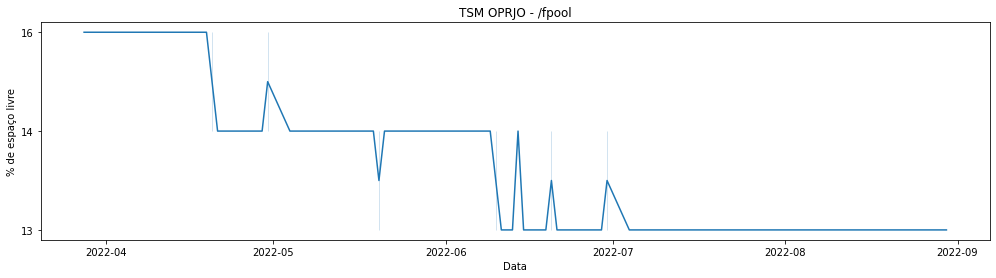

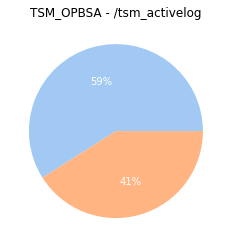

In [14]:
TSM_OPRJO_fpool = df_vol_TSM_OPRJO[df_vol_TSM_OPRJO['particao'] == '/tsm_fpool']
#TSM_OPRJO_fpool = TSM_OPRJO_fpool.drop_duplicates(subset='porcentagem')
TSM_OPRJO_fpool.reset_index(drop=True, inplace=True)
plt.figure(figsize = (17,4))
fpool = sns.lineplot(data = TSM_OPRJO_fpool, x = 'data', y = 'porcentagem')
fpool.set_xlabel('Data', fontsize = 10)
fpool.set_ylabel('% de espaço livre', fontsize = 10)
fpool.set_title('TSM OPRJO - /fpool')
TSM_OPRJO_fpool.head()
# ---------------------------------
TSM_OPBSA_activelog = df_vol_TSM_OPBSA[df_vol_TSM_OPBSA['particao'] == '/tsm_activelog']
TSM_OPBSA_activelog.reset_index(drop=True, inplace=True)
print(TSM_OPBSA_activelog['porcentagem'].iloc[-1])
valor = [TSM_OPBSA_activelog['porcentagem'].iloc[-1], 100 - int(TSM_OPBSA_activelog['porcentagem'].iloc[-1])]
legenda = ['Em uso', 'Livre']
cores = sns.color_palette('pastel')[0:5]
plt.figure(figsize = (10,4))
plt.pie(valor, labels = legenda, colors = cores, autopct='%.0f%%', textprops={'color':"w"})
plt.title('TSM_OPBSA - /tsm_activelog')
plt.show()

MACHINE LEARNING

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# Tratamento dos dados para o treinamento
#...
Xtrain, Xval, Ytrain, Yval = train_test_split(TSM_OPRJO_fpool['data'], TSM_OPRJO_fpool['porcentagem'], test_size=0.3, random_state=0)
print(Xtrain.shape, Xval.shape, Ytrain.shape, Yval.shape)

modelo = LinearRegression(n_jobs=4, normalize=True)
modelo.fit(Xtrain, Ytrain)
previsao = modelo.predict(Xval)